In [1]:
%pip install pytrends

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [3]:

def polynomialRegression(dataframe, column, order):
    indexs_2 = np.array([i for i in range(len(dataframe[column].values))])
    indexs_2 = np.reshape(indexs_2, newshape=(1,-1))[0]

    RMSEs = []
    for i in range(order):
        features = PolynomialFeatures(degree=i+1)
        x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
        
        model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

        train_pred = model.predict(x_train_transformed)
        rmse_poly_4_train = mean_squared_error(dataframe[column].values, train_pred, squared = False)
        RMSEs.append(rmse_poly_4_train)

    features = PolynomialFeatures(degree=RMSEs.index(min(RMSEs))+1)
    x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
    model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

    x_test_transformed = features.fit_transform(indexs_2.reshape(-1, 1))

    train_pred = model.predict(x_train_transformed)

    test_pred = model.predict(x_test_transformed)
    
    dataframe[f'Poly_{column}'] = test_pred
    return test_pred        

In [4]:
import requests
import pandas as pd
from datetime import datetime

In [5]:
SYMBOL = 'BTC'

response = requests.get(f'https://crypto-api.zlochteam.com/get-crypto-{SYMBOL}/change-candles?timeframe=15&indicators=true').json()
print(f'{response["total"]} records in the dataset for {SYMBOL}')

df = pd.DataFrame(response['data'])
df['Date'] = df['timestamp'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
df.tail()

2603 records in the dataset for BTC


,%D,%K,Acceleration,Bearish_engulfing,Bollinger_high,Bollinger_low,Bullish_engulfing,EMA100,EMA20,EMA200,...,RSI,Slope,Vortex_neg,Vortex_pos,close,high,low,open,symbol,timestamp
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-13 10:24:15,0.112013,0.067576,93.99,0.0,30228.631735,30701.768265,0.0,29471.585668,30286.606167,29738.956542,...,54.342308,-38.44,0.699771,0.751698,30270.62,30313.71,30230.02,30278.12,BTC,1652430255
2022-05-13 10:39:40,0.067233,0.007802,55.08,0.0,30223.960619,30703.960381,1.0,29487.737635,30286.668437,29744.412298,...,54.914553,16.64,0.772433,0.725434,30287.26,30324.69,30230.86,30257.12,BTC,1652431180
2022-05-13 10:55:08,0.031122,0.017988,-11.76,0.0,30210.815185,30708.563815,0.0,29503.666394,30287.189538,29749.862325,...,55.092315,4.88,0.785396,0.732794,30292.14,30431.21,30271.32,30319.34,BTC,1652432108
2022-05-13 11:10:31,0.026265,0.053006,44.75,0.0,30198.483032,30704.812968,0.0,29520.262505,30292.387678,29755.751954,...,56.951285,49.63,0.836871,0.726155,30341.77,30435.29,30316.04,30432.62,BTC,1652433031
2022-05-13 12:03:20,0.066728,0.129189,50.76,0.0,30196.855375,30702.474625,0.0,29538.517901,30306.651708,29762.581885,...,60.512080,100.39,0.725706,0.777986,30442.16,30692.95,30427.78,30490.88,BTC,1652436200


In [6]:
from pytrends.request import TrendReq
import pytz
import warnings

warnings.filterwarnings('ignore')

pytrends = TrendReq(hl='en-US', tz=360) 
kw_list = ["BTC","Blockchain","Bitcoin","ETH"] # list of keywords to get data 

pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 
data = pytrends.get_historical_interest(kw_list, year_start=df.index[0].year, month_start=df.index[0].month, day_start=df.index[0].day, hour_start=0, year_end=datetime.now().year, month_end=datetime.now().month, day_end=datetime.now().day, hour_end=0, cat=0, sleep=0)
data = data.reset_index() 
data.set_index('date',inplace=True)
data.BTC = data.BTC + data.Bitcoin

window=20

data[f'BTC_SMA{window}'] =  data.BTC.rolling(window).mean()
data[f'Blockchain_SMA{window}'] =  data.Blockchain.rolling(window).mean()
data[f'ETH_SMA{window}'] =  data.Blockchain.rolling(window).mean()
data.drop(columns=['Bitcoin','isPartial'],inplace=True)
data.dropna(inplace=True)

polynomialRegression(data,'BTC',20)
polynomialRegression(data,'Blockchain',20)
polynomialRegression(data,'ETH',20)

print(f'Total records {len(data)}')
data.head()

Total records 609


,BTC,Blockchain,ETH,BTC_SMA20,Blockchain_SMA20,ETH_SMA20,Poly_BTC,Poly_Blockchain,Poly_ETH
date,,,,,,,,,
2022-04-17 19:00:00,95,7,9,83.75,5.30,5.30,96.377921,6.575273,8.700287
2022-04-17 20:00:00,91,3,8,83.95,5.25,5.25,96.377921,6.575273,8.700287
2022-04-17 21:00:00,99,5,8,84.30,5.25,5.25,96.377921,6.575273,8.700287
2022-04-17 22:00:00,106,7,12,85.75,5.40,5.40,96.377921,6.575273,8.700287
2022-04-17 23:00:00,107,6,9,87.40,5.40,5.40,96.377921,6.575273,8.700287


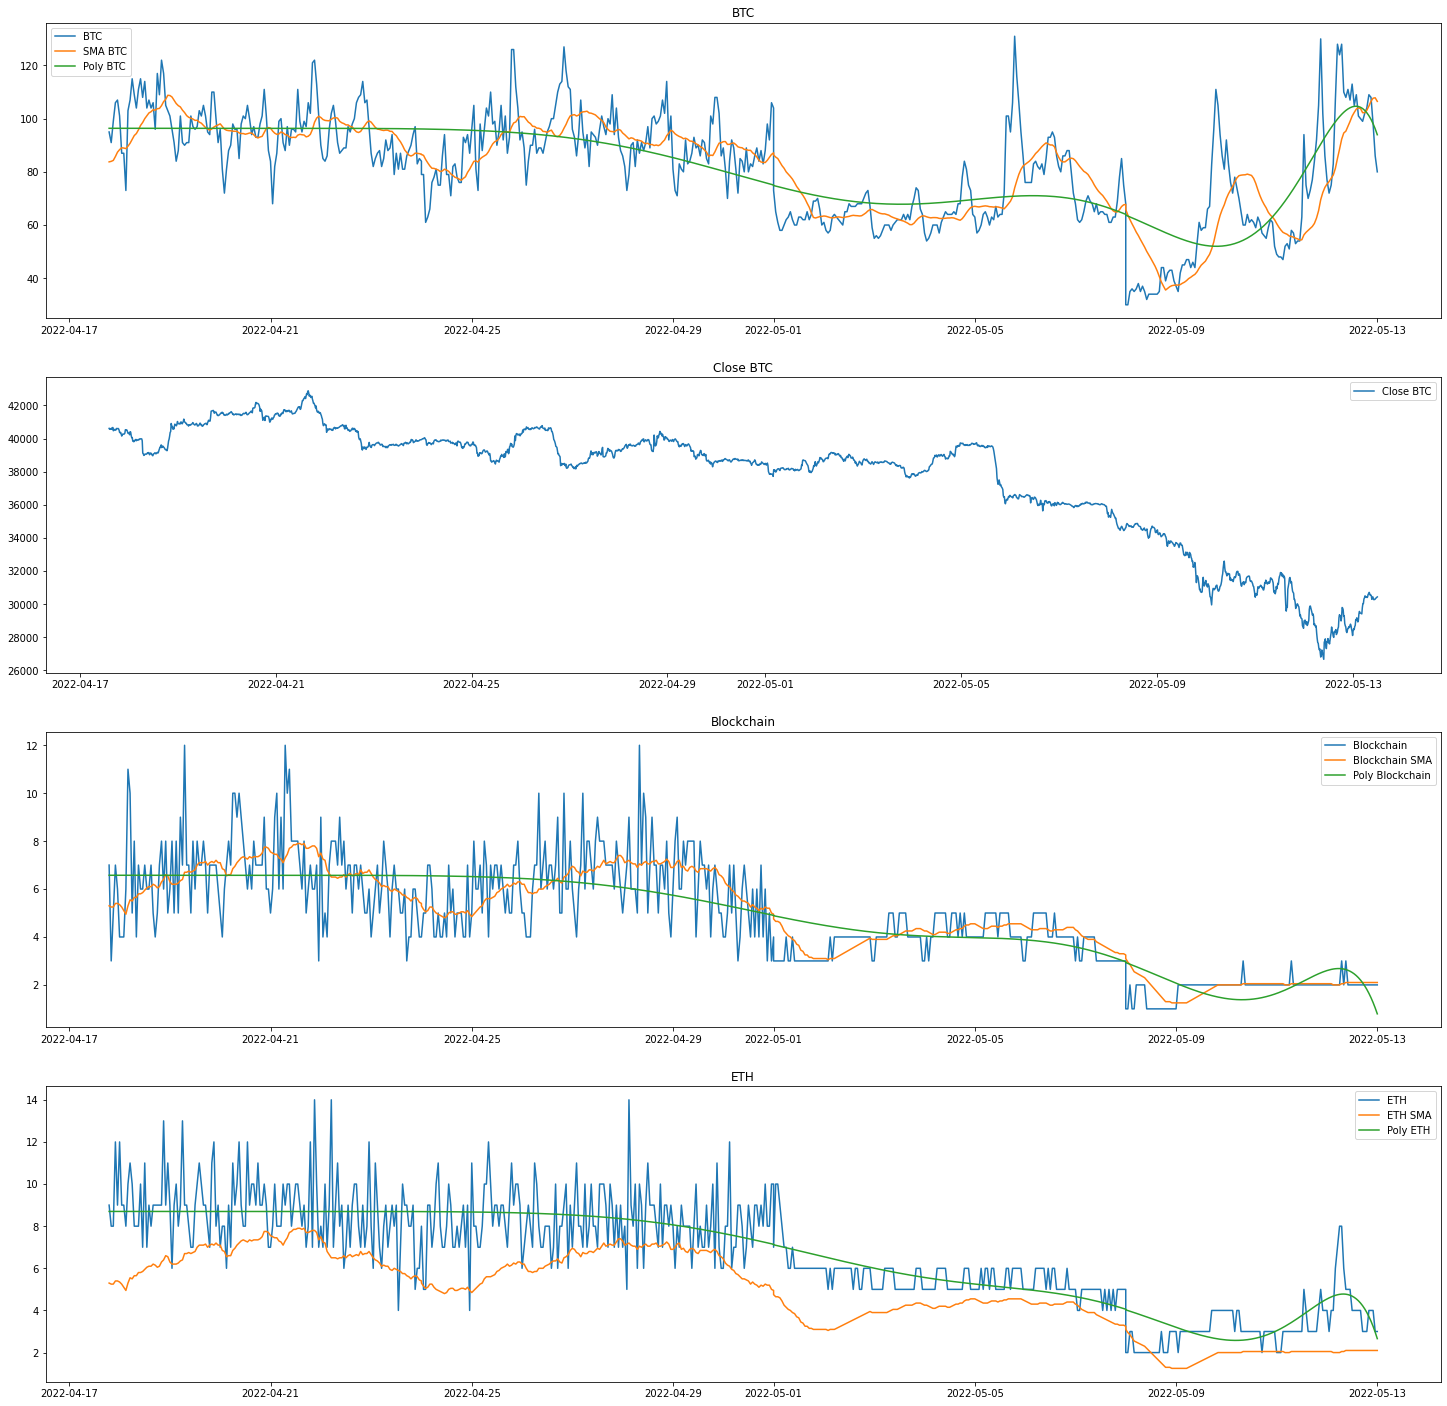

In [7]:
fig, ax1 = plt.subplots(4, 1,figsize=(25,25))
#fig.suptitle(f'Close')
ax1[0].plot(data.BTC, label='BTC')
ax1[0].plot(data[f'BTC_SMA{window}'], label=f'SMA BTC')
ax1[0].plot(data.Poly_BTC, label='Poly BTC')
#ax1[0].plot(data.Bitcoin, label='Bitcoin')
ax1[0].legend(loc="upper left")
ax1[0].set_title(f'BTC')
ax1[2].plot(data.Blockchain, label='Blockchain')
ax1[2].plot(data[f'Blockchain_SMA{window}'], label='Blockchain SMA')
ax1[2].plot(data.Poly_Blockchain, label='Poly Blockchain')
ax1[2].set_title(f'Blockchain')
ax1[2].legend(loc="upper right")
ax1[3].plot(data['ETH'], label='ETH')
ax1[3].plot(data[f'ETH_SMA{window}'], label='ETH SMA')
ax1[3].plot(data.Poly_ETH, label='Poly ETH')
ax1[3].set_title(f'ETH')
ax1[3].legend(loc="upper right")
ax1[1].plot(df['close'], label='Close BTC')
ax1[1].set_title(f'Close BTC')
ax1[1].legend(loc="upper right")

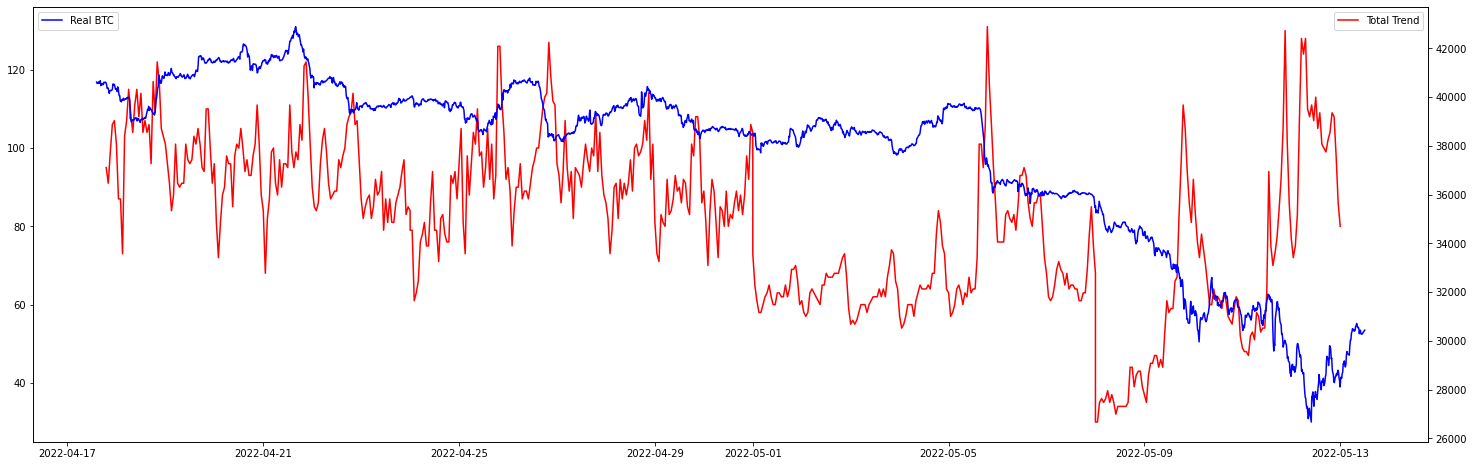

In [8]:
fig, ax_left = plt.subplots(figsize=(25,8))
ax_right = ax_left.twinx()

data['feature'] =data.BTC
#ax_left.plot(data.BTC, color='red',label='BTC Trend')
ax_left.plot(data.feature, color='red',label='Total Trend')
#ax_left.plot(data.Blockchain, color='orange',label='Blockchain Trend')
ax_right.plot(df.close, color='blue',label='Real BTC')
ax_left.legend(loc="upper right")
ax_right.legend(loc="upper left")

In [ ]:
plt.scatter(data.feature,df.close[11:-9].values,)

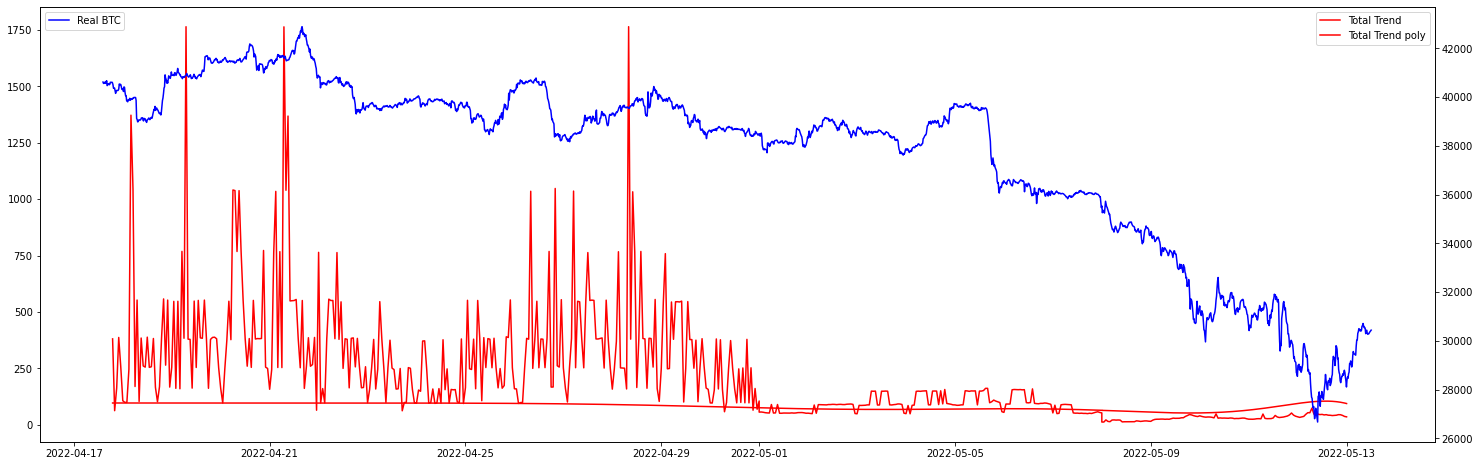

In [10]:
polynomialRegression(data,'feature',20)
fig, ax_left = plt.subplots(figsize=(25,8))
ax_right = ax_left.twinx()

data['feature'] = data.Blockchain**3+data.ETH+0.3*data.BTC
#ax_left.plot(data.BTC, color='red',label='BTC Trend')
ax_left.plot(data.feature, color='red',label='Total Trend')
ax_left.plot(data.Poly_feature, color='red',label='Total Trend poly')
#ax_left.plot(data.Blockchain, color='orange',label='Blockchain Trend')
ax_right.plot(df.close, color='blue',label='Real BTC')
ax_left.legend(loc="upper right")
ax_right.legend(loc="upper left")